# Адамцевич А.О.

## Курсовой проект для курса "Python для Data Science"

### Задание для курсового проекта

Материалы к проекту (файлы):
train.csv
test.csv

Задание:
Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).

Целевая переменная:
Price

Метрика качества:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Требования к решению:
1. R2 > 0.6
2. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}_solution.ipynb, пример SShirkin_solution.ipynb
3. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}_predictions.csv, пример SShirkin_predictions.csv 
Файл должен содержать два поля: Id, Price и в файле должна быть 5001 строка (шапка + 5000 предсказаний).

Сроки сдачи:
Cдать проект нужно в течение 72 часов после окончания последнего вебинара. Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества. Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

Описание датасета:
Id - идентификационный номер квартиры
DistrictId - идентификационный номер района
Rooms - количество комнат
Square - площадь
LifeSquare - жилая площадь
KitchenSquare - площадь кухни
Floor - этаж
HouseFloor - количество этажей в доме
HouseYear - год постройки дома
Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
Social_1, Social_2, Social_3 - социальные показатели местности
Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
Price - цена квартиры

**Подключение библиотек и скриптов**

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.rcParams.update({'font.size': 14})

import warnings
warnings.filterwarnings('ignore')

matplotlib.rcParams["figure.figsize"] = 18, 10
# %config InlineBackend.figure_format = 'svg'

**Функции**

In [2]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))

    plt.figure(figsize=(18,10))
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [3]:
def fix_data(data):
    square_med_diff = (data.loc[data['LifeSquare'].notnull(), 'Square'] -\
                       data.loc[data['LifeSquare'].notnull(), 'LifeSquare'] -\
                       data.loc[data['LifeSquare'].notnull(), 'KitchenSquare']).median()
    data.loc[data['LifeSquare'].isnull(), 'LifeSquare'] = 0
    
    data['Id'] = data['Id'].astype(str)
    data['DistrictId'] = data['DistrictId'].astype(str)
    data['HouseFloor'] = data['HouseFloor'].astype(int)
    
    data['Rooms'] = data['Rooms'].astype(int)
    data['Square'] = data['Square'].astype(int)
    data['LifeSquare'] = data['LifeSquare'].astype(int)
    data['KitchenSquare'] = data['KitchenSquare'].astype(int)
    data['Ecology_1'] = data['Ecology_1'].astype(int)


    data.loc[data['Rooms'] == 0, 'Rooms'] = 1
    data.loc[data['Rooms'].isin([10, 19]), 'Rooms'] = 6
    data.loc[data['LifeSquare'] < 10, 'LifeSquare'] = data['Square'] - data['KitchenSquare'] - square_med_diff
    data.loc[data['KitchenSquare'] < 4, 'KitchenSquare'] = 4
    data.loc[data['HouseFloor'] == 0, 'HouseFloor'] = data['HouseFloor'].median()
    data.loc[data['Floor'] > data['HouseFloor'], 'Floor'] = data['HouseFloor']
    data.loc[data['KitchenSquare'] > data['LifeSquare'] / 2, 'KitchenSquare'] = data['KitchenSquare'].median()
    data.loc[data['HouseYear'] > 2020, 'HouseYear'] = 2020
    
    data.loc[data['Healthcare_1'].isnull(), 'Healthcare_1'] = data['Healthcare_1'].median()
    
    return data

In [4]:
def scatter_main(data):
    fig, ax = plt.subplots(4, 1)
    ax1, ax2, ax3, ax4 = ax.flatten()

    fig.set_size_inches(18, 18)
    fig.subplots_adjust(wspace=0.2, hspace=0.3)

    x1 = data['Square']
    y1 = data['KitchenSquare']
    ax1.set_xlabel('Общая площадь')
    ax1.set_ylabel('Площадь кухни')

    x2 = data['Square']
    y2 = data['LifeSquare']
    ax2.set_xlabel('Общая площадь')
    ax2.set_ylabel('Жилая площадь')

    x3 = data['HouseFloor']
    y3 = data['Floor']
    ax3.set_xlabel('Этажность дома')
    ax3.set_ylabel('Этаж квартиры')
    
    x4 = data['LifeSquare']
    y4 = data['KitchenSquare']
    ax4.set_xlabel('Жилая площадь')
    ax4.set_ylabel('Площадь кухни')

    ax1.scatter(x1, y1)
    ax2.scatter(x2, y2)
    ax3.scatter(x3, y3)
    ax4.scatter(x4, y4)

In [5]:
def new_signs(data):
    
    data['Ecology_2_bin'] = data['Ecology_2'].replace({'A':0, 'B':1})
    data['Ecology_3_bin'] = data['Ecology_3'].replace({'A':0, 'B':1})
    data["Eco"] = data.Ecology_2_bin + data.Ecology_3_bin
    data['Shops_2_bin'] = data['Shops_2'].replace({'A':0, 'B':1})
    
    # DistrictSize, IsDistrictLarge
    district_size = data['DistrictId'].value_counts(normalize=True).reset_index()\
                   .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
    data = data.merge(district_size, on='DistrictId', how='left')
    data['IsDistrictLarge'] = (data['DistrictSize'] > 0.03).astype(int)
    
    # MedHouseFloorByDistrict
    med_HouseFloor_by_district = data.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'HouseFloor':'median'})\
                               .rename(columns={'HouseFloor':'MedHouseFloorByDistrict'})
    data = data.merge(med_HouseFloor_by_district, on=['DistrictId', 'Rooms'], how='left')
    
    # MedHouseYearByDistrict
    med_HouseYear_by_district = data.groupby(['DistrictId', 'LifeSquare'], as_index=False).agg({'HouseYear':'median'})\
                               .rename(columns={'HouseYear':'MedHouseYearByDistrict'})
    data = data.merge(med_HouseYear_by_district, on=['DistrictId', 'LifeSquare'], how='left')
    

    return data

### Загрузка данных

In [6]:
TRAIN_DATASET_PATH = 'data/train.csv' # y_train, y_valid
TEST_DATASET_PATH = 'data/test.csv'
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [7]:
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
9997,5123,27,1.0,47.939008,NaN,1.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808
9999,6306,128,1.0,38.666645,21.157874,8.0,7,17.0,1990,0.000000,B,B,27,4798,0,30.0,2,8,B,218714.077615


In [8]:
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,B,B,36,5992,0,NaN,1,1,B
4996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,B,B,1,264,0,NaN,0,1,B
4997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,B,B,74,19083,2,NaN,5,15,B
4998,4780,62,2.0,81.305222,NaN,0.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A
4999,12504,30,2.0,60.555693,NaN,1.0,10,17.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B


### Обзор данных

In [9]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

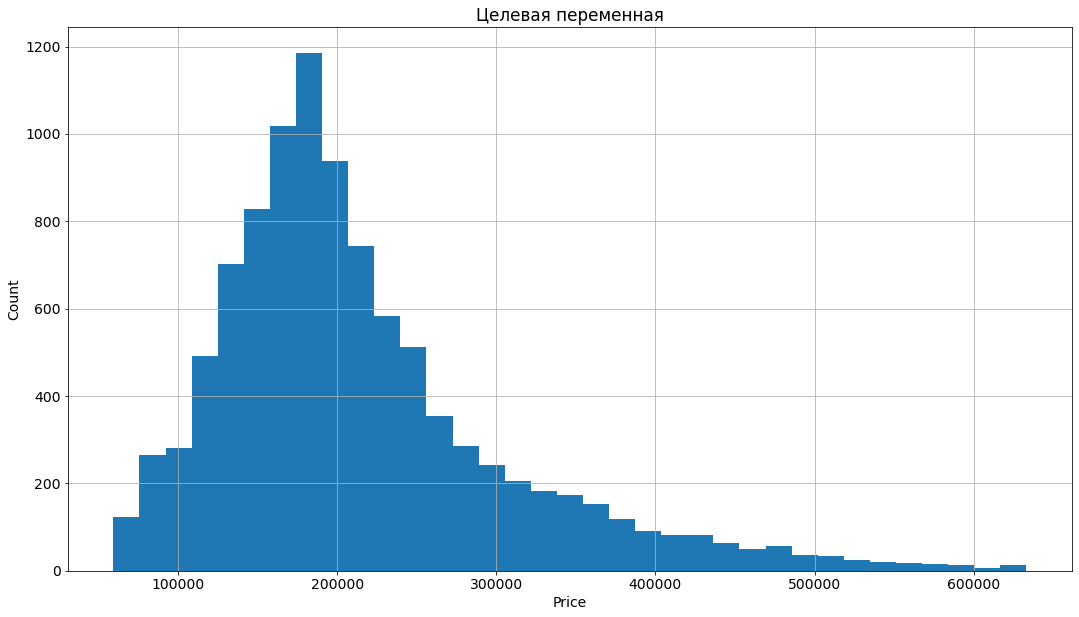

In [10]:
plt.figure()
train_df['Price'].hist(bins=35)
plt.ylabel('Count')
plt.xlabel('Price')
plt.title('Целевая переменная')
plt.show()

## Обработка данных

In [11]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [12]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64

In [13]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [14]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [15]:
train_df['HouseYear'].value_counts().sort_index()

1910          1
1912          2
1914          1
1916          1
1917          3
           ... 
2018        175
2019         79
2020         19
4968          1
20052011      1
Name: HouseYear, Length: 97, dtype: int64

In [16]:
len(train_df) - train_df.count()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [17]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

,Square,LifeSquare,KitchenSquare
0,47.981561,29.442751,6.0
1,65.683640,40.049543,8.0
2,44.947953,29.197612,0.0
3,53.352981,52.731512,9.0
4,39.649192,23.776169,7.0
5,80.384479,46.683720,12.0
6,62.254114,37.160377,7.0
7,80.312926,NaN,0.0
8,64.511437,NaN,1.0
9,46.461409,18.915552,8.0


In [18]:
train_df['Healthcare_1'].head()

0       NaN
1     240.0
2     229.0
3    1084.0
4    2078.0
Name: Healthcare_1, dtype: float64

In [19]:
mask = train_df["Square"] < train_df["KitchenSquare"] + train_df["LifeSquare"]
train_df.loc[mask].describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,313.000000,845.000000,845.000000,845.000000
mean,8303.366864,35.454438,1.766864,59.145433,68.782054,11.160947,9.797633,14.101775,2000.353846,0.105389,16.360947,3771.007101,8.663905,882.322684,0.871006,3.528994,200907.622912
std,4911.706908,29.982054,0.824012,32.663061,257.842899,97.293152,6.024869,8.652264,19.752893,0.109640,17.079439,3982.369298,28.699550,721.557527,1.368631,5.267550,99063.886453
min,10.000000,0.000000,1.000000,1.136859,1.626502,0.000000,1.000000,0.000000,1918.000000,0.000000,0.000000,168.000000,0.000000,30.000000,0.000000,0.000000,59877.592523
25%,4020.000000,22.000000,1.000000,41.481906,41.675761,1.000000,5.000000,9.000000,1977.000000,0.014073,2.000000,629.000000,0.000000,540.000000,0.000000,0.000000,133166.163513
50%,8143.000000,27.000000,2.000000,53.258610,53.983730,1.000000,8.000000,17.000000,2015.000000,0.072158,8.000000,1564.000000,1.000000,705.000000,0.000000,1.000000,177948.133001
75%,12493.000000,52.000000,2.000000,68.767146,68.712203,10.000000,14.000000,17.000000,2017.000000,0.195781,26.000000,6207.000000,4.000000,1046.000000,1.000000,5.000000,237969.144323
max,16781.000000,187.000000,5.000000,641.065193,7480.592129,2014.000000,28.000000,117.000000,2020.000000,0.486246,74.000000,19083.000000,141.000000,4508.000000,6.000000,23.000000,621002.912679


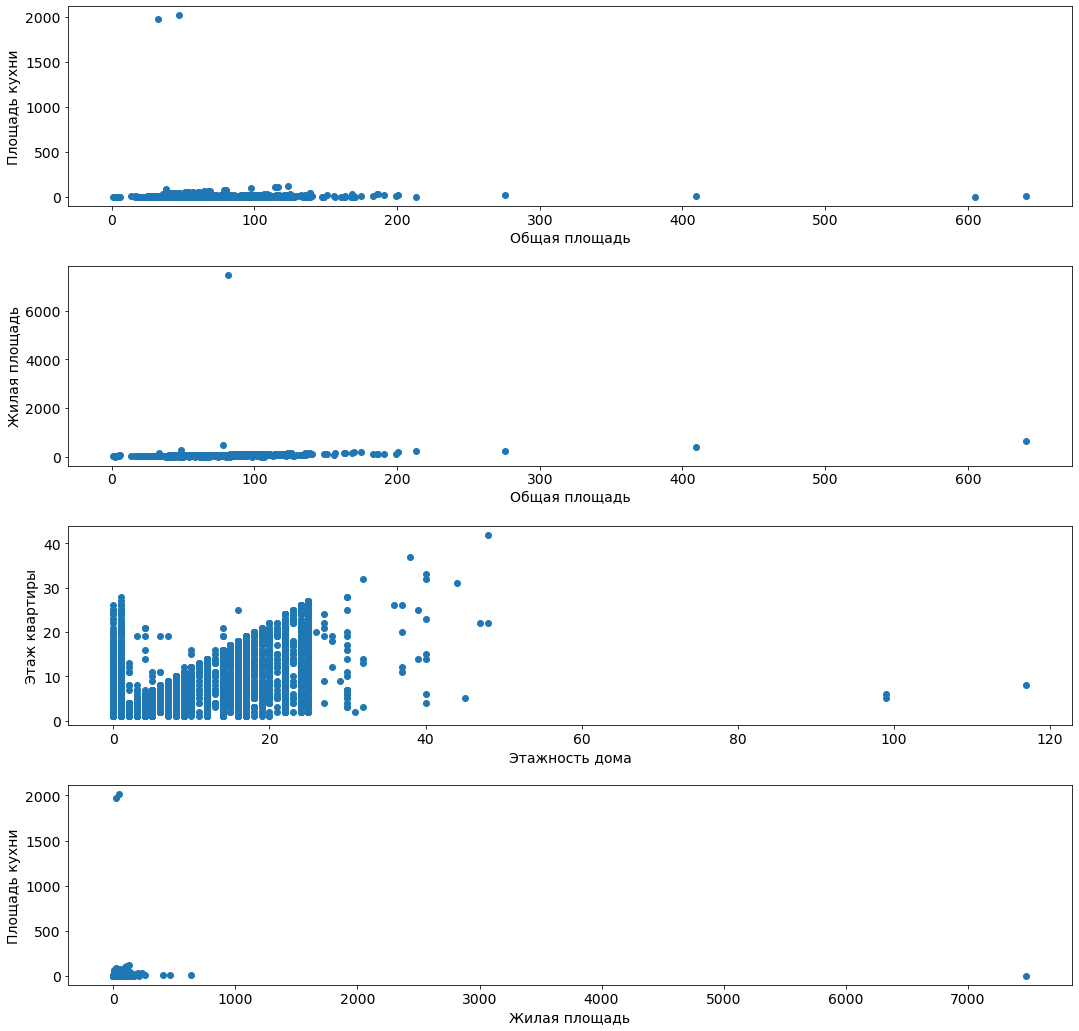

In [20]:
scatter_main(train_df)

In [21]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64

In [22]:
train_df = train_df[train_df['Square'].isnull() |
                    (train_df['Square'] < train_df['Square'].quantile(.99)) &
                    (train_df['Square'] > train_df['Square'].quantile(.01))]

train_df = train_df[train_df['LifeSquare'].isnull() |
                    (train_df['LifeSquare'] < train_df['LifeSquare'].quantile(.98)) &
                    (train_df['LifeSquare'] > train_df['LifeSquare'].quantile(.02))]

train_df = train_df[train_df['KitchenSquare'].isnull() |
                    (train_df['KitchenSquare'] < train_df['KitchenSquare'].quantile(.99)) &
                    (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.01))]

fix_data(train_df)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2,47,29.000000,6,7,9,1969,0,B,B,33,7976,5,990.0,0,11,B,184966.930730
1,15053,41,3,65,40.000000,8,7,9,1978,0,B,B,46,10309,1,240.0,1,16,B,300009.450063
3,5809,58,2,53,52.000000,9,8,17,1977,0,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1,39,23.000000,7,11,12,1976,0,B,B,35,5776,1,2078.0,2,4,B,150226.531644
5,12915,59,3,80,46.000000,12,5,17,2011,0,B,B,35,7715,4,990.0,0,6,B,215898.447742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,77,32,2,50,30.000000,5,5,5,1968,0,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1,41,20.000000,9,13,13,2000,0,B,B,30,5562,0,990.0,0,5,A,189050.289571
9997,5123,27,1,47,34.529682,4,12,16,2015,0,B,B,2,629,1,990.0,0,0,A,159143.805370
9998,5400,75,2,43,33.000000,8,1,5,1961,0,B,A,30,5048,9,325.0,2,5,B,181595.339808


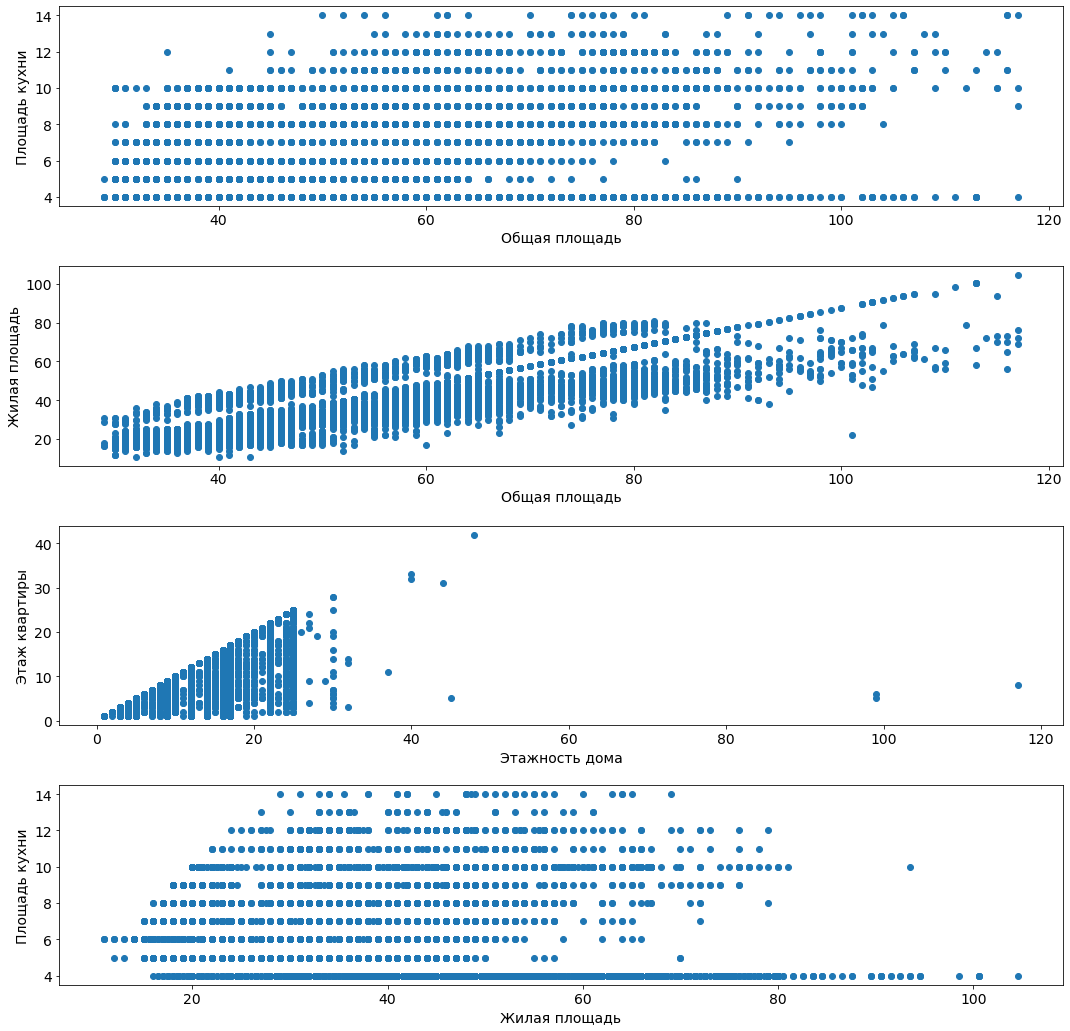

In [23]:
scatter_main(train_df)

### Построение новых признаков

In [24]:
train_df.dtypes

Id                object
DistrictId        object
Rooms              int32
Square             int32
LifeSquare       float64
KitchenSquare      int32
Floor              int64
HouseFloor         int32
HouseYear          int64
Ecology_1          int32
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [25]:
cat_colnames = train_df.select_dtypes(include='object').columns.tolist()
cat_colnames

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [26]:
train_df['DistrictId'].value_counts()

27     608
1      528
23     445
6      371
9      274
      ... 
207      1
117      1
199      1
196      1
209      1
Name: DistrictId, Length: 205, dtype: int64

In [27]:
for cat_colname in cat_colnames[2:]:
    print(str(cat_colname) + '\n\n' + str(train_df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Ecology_2

B    8669
A      89
Name: Ecology_2, dtype: int64
****************************************************************************************************

Ecology_3

B    8492
A     266
Name: Ecology_3, dtype: int64
****************************************************************************************************

Shops_2

B    8152
A     606
Name: Shops_2, dtype: int64
****************************************************************************************************



In [28]:
train_df = new_signs(train_df)
test_df = new_signs(test_df)

In [29]:
train_df.shape[1]-1 == test_df.shape[1]

True

### Отбор признаков

In [30]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'Eco',
 'Shops_2_bin',
 'DistrictSize',
 'IsDistrictLarge',
 'MedHouseFloorByDistrict',
 'MedHouseYearByDistrict']

In [31]:
train_df.dtypes

Id                          object
DistrictId                  object
Rooms                        int32
Square                       int32
LifeSquare                 float64
KitchenSquare                int32
Floor                        int64
HouseFloor                   int32
HouseYear                    int64
Ecology_1                    int32
Ecology_2                   object
Ecology_3                   object
Social_1                     int64
Social_2                     int64
Social_3                     int64
Healthcare_1               float64
Helthcare_2                  int64
Shops_1                      int64
Shops_2                     object
Price                      float64
Ecology_2_bin                int64
Ecology_3_bin                int64
Eco                          int64
Shops_2_bin                  int64
DistrictSize               float64
IsDistrictLarge              int32
MedHouseFloorByDistrict    float64
MedHouseYearByDistrict     float64
dtype: object

In [32]:
feature_names = ['Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2_bin',
 'IsDistrictLarge',
 'MedHouseFloorByDistrict',
 'MedHouseYearByDistrict',
 'Eco']

target_name = 'Price'

### Разбиение на train и test

In [33]:
X = train_df[feature_names]
y = train_df[target_name]

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, shuffle=True, random_state=99
)

In [35]:
train_df.shape

(8758, 28)

In [36]:
test_df.shape

(5000, 27)

### Построение модели

**Обучение и оценка модели**

In [37]:
rf_model = RandomForestRegressor(max_depth=10, max_features=6, min_samples_leaf=3, n_estimators=300, random_state=39)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, max_features=6, min_samples_leaf=3,
                      n_estimators=300, random_state=39)

**Отложенная выборка**

Train R2:	0.805
Test R2:	0.701


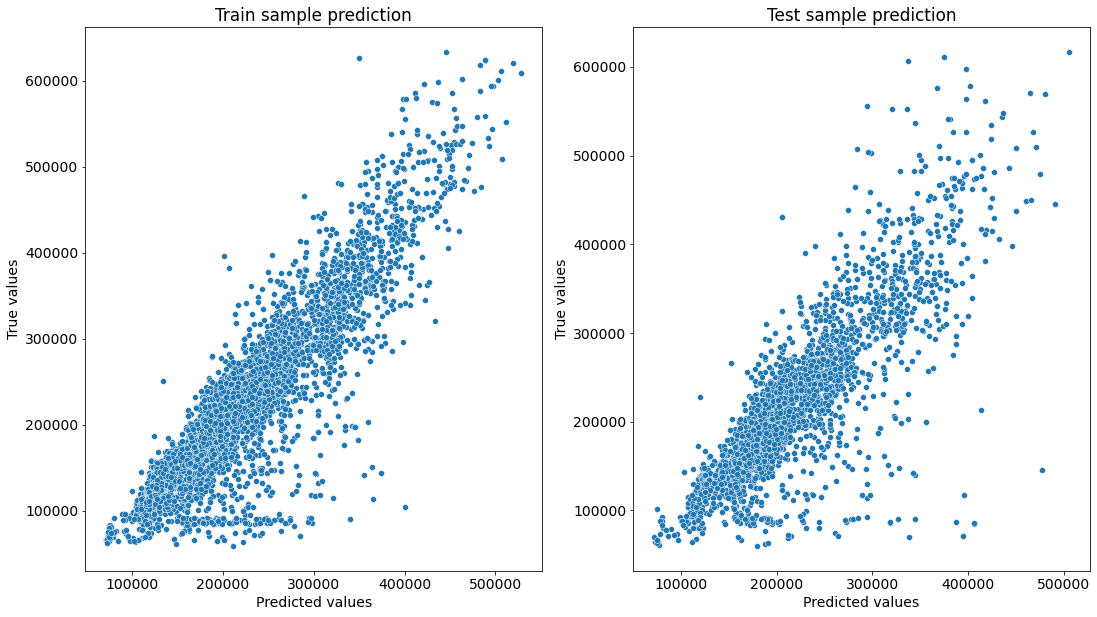

In [38]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)
evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

**Перекрёстная проверка**

In [39]:
cv_score = cross_val_score(
    rf_model,
    X.fillna(-9999),
    y, scoring='r2',
    cv=KFold(n_splits=6, shuffle=True, random_state=21)
)
cv_score

array([0.74818905, 0.71045446, 0.70000721, 0.70284884, 0.67334799,
       0.68730597])

In [40]:
cv_score.mean(), cv_score.std()

(0.7036922553056839, 0.02319938019143618)

In [41]:
cv_score.mean() - cv_score.std(), cv_score.mean() + cv_score.std()

(0.6804928751142477, 0.7268916354971201)

**Важность признаков**

In [42]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.292727
0,Rooms,0.146976
2,LifeSquare,0.080497
8,Social_2,0.077630
7,Social_1,0.070940
9,Social_3,0.059521
3,KitchenSquare,0.052917
14,IsDistrictLarge,0.051747
16,MedHouseYearByDistrict,0.033054
6,HouseYear,0.029366


## Формирование файла с прогнозами

In [43]:
test_id = test_df["Id"]
pred_df = pd.DataFrame()
pred_df["Id"] = test_id
pred_df["Price"] = np.random.randint(0, 1e6, size=test_id.shape[0])
assert pred_df.shape[0] == 5000, f"Real pred-shape = {pred_df.shape[0]}, Expected pred-shape = 5000"

pred_df.to_csv("predictions_.csv", index=False)

In [44]:
pred_df = pd.read_csv("predictions_.csv")
pred_df.head(n=10)

,Id,Price
0,725,490738
1,15856,48500
2,5480,54850
3,15664,860987
4,14275,234811
5,7633,441786
6,13329,901089
7,5502,281346
8,4220,661497
9,11538,855033


In [45]:
test_df.shape[0]

5000